# Monte Carlo Learning

In [1]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print ("plt version:[%s]"%(matplotlib.__version__))
print ("gym version:[%s]"%(gym.__version__))

plt version:[3.3.4]
gym version:[0.18.0]


In [2]:
def visualize_matrix(M,strs='',fontsize=15,cmap='turbo',title='Title',title_fs=15,
                     fig_size=8,REMOVE_TICK_LABELS=True):
    """
    Visualize a matrix colors and strings 
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = M.shape[0],M.shape[1]
    fig,ax = plt.subplots(figsize=(fig_size,fig_size))
    divider = make_axes_locatable(ax)
    im = ax.imshow(M,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0),
              interpolation='nearest',aspect='equal')
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    ax.set_frame_on(False)
    x,y = np.meshgrid(np.arange(0,n_col,1.0),np.arange(0,n_row,1.0))
    if len(strs) == n_row*n_col:
        idx = 0
        for x_val,y_val in zip(x.flatten(), y.flatten()):
            c = strs[idx]
            idx = idx + 1
            ax.text(x_val+0.5,y_val+0.5,c,va='center', ha='center',size=fontsize)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    plt.show()
print ("Done.")

Done.


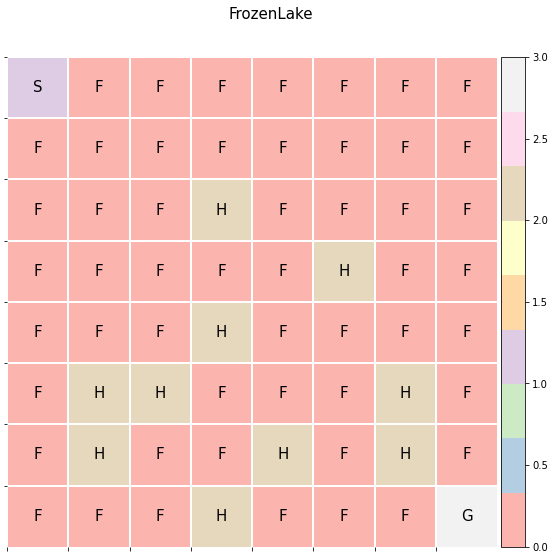

In [3]:
E = np.zeros(shape=(8,8))
strs = ['S','F','F','F','F','F','F','F',
       'F','F','F','F','F','F','F','F',
       'F','F','F','H','F','F','F','F',
       'F','F','F','F','F','H','F','F',
       'F','F','F','H','F','F','F','F',
       'F','H','H','F','F','F','H','F',
       'F','H','F','F','H','F','H','F',
       'F','F','F','H','F','F','F','G']
E[0,0] = 1 # Start
E[2,3]=E[3,5]=E[4,3]=E[5,1]=E[5,2]=E[5,6]=E[6,1]=E[6,4]=E[6,6]=E[7,3]=2 # Hole
E[7,7] = 3 # Goal
visualize_matrix(E,strs=strs,cmap='Pastel1',title='FrozenLake')

Policy Iteration with Q-Value
--
---
Policy Evaluation

- $V_{k}(s) = \sum_{a'} \pi_{k}(a'|s) Q_{k}(s,a')$

- $Q_{k+1}(s,a) = \sum_{a'} \left[r(s,a,s') + \gamma V_{k}(s') \right] P(s'|s,a)$

Policy Improvement

- $\pi_{k+1}(a|s) = \mathbf{1}\left(a = \max_{a'} Q_{k+1}(s,a')\right)$

In [4]:
def q_policy_evaluation(env,P,r,Pi,gamma=0.99,epsilon=1e-6):
    """
    Policy evaluation 
     env   : environment
     P     : state transition probability [S x A x S]
     r     : reward [S]
     Pi    : policy [S x A]
    returns
     Q     : Q-value [S x A]
    """
    # Extract environment information
    n_state = env.observation_space.n
    n_action = env.action_space.n
    # Randomly initialize Q
    Q = np.random.uniform(size=(n_state,n_action))
    while True:
        V = np.sum(Pi*Q,axis=1) # [S]
        V_tile = np.tile(V[np.newaxis,np.newaxis,:],reps=(n_state,n_action,1)) # [S x A x S]
        Q_prime = np.sum((r+gamma*V_tile)*P,axis=2) # [S x A]
        Q_dist = np.max(np.max(np.abs(Q-Q_prime)))
        Q = Q_prime
        if Q_dist < epsilon:
            break
    return Q

def q_policy_improvement(env,Q):
    """
    Policy improvement
     env   : environment
     Q     : Q-value [S x A]
    """
    # Extract environment information
    n_state = env.observation_space.n
    n_action = env.action_space.n
    Pi = np.zeros((n_state,n_action))
    Pi[np.arange(n_state),np.argmax(Q,axis=1)] = 1 # Greedy policy update
    return Pi

def q_policy_iteration(env,gamma=0.99,epsilon=1e-6):
    """
    Policy iteration
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    # Random initial policy
    Pi = np.random.uniform(size=(n_state,n_action))
    Pi = Pi/np.sum(Pi,axis=1,keepdims=True)
    # Parse P and r from the environment
    P = np.zeros((n_state,n_action,n_state))
    r = np.zeros((n_state,n_action,n_state))
    for s in env.unwrapped.P.keys(): # for all states s
        for a in env.unwrapped.P[s].keys(): # for all actions a
            for prob,s_prime,reward,done in env.unwrapped.P[s][a]:
                P[s][a][s_prime] = prob
                r[s][a][s_prime] = reward
    # Loop
    while True:
        Q = q_policy_evaluation(env,P,r,Pi,gamma=gamma,epsilon=epsilon) # policy evaluation
        Pi_prime = q_policy_improvement(env,Q) # policy improvement
        if (Pi == Pi_prime).all(): # if policy does not change
            break
        Pi = Pi_prime # update new policy
    return Pi,Q

print ("Done.")

Done.


In [5]:
def display_q_value(Q, title="Q Function",fig_size=8,text_fs=9,title_fs=15):
    """
    Display Q value
    """
    n_state, n_action = Q.shape
    nRow = 8
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])
    # Color
    high_color = np.array([1.0, 0.0, 0.0, 0.8])
    low_color  = np.array([1.0, 1.0, 1.0, 0.8])
    fig = plt.figure(figsize=(fig_size,fig_size))
    plt.title(title,fontsize=title_fs)  
    for i in range(nRow):
        for j in range(nRow):
            s = i*nRow+j
            min_q = np.min(Q[s])
            max_q = np.max(Q[s])
            for a in range(n_action):
                q_value = Q[s,a]
                ratio = (q_value - min_q)/(max_q - min_q + 1e-10) 
                if ratio > 1: clr = high_color
                elif ratio < 0: clr = low_color
                else: clr = high_color*ratio + low_color*(1-ratio)
                if a == 0: # Left arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+lft_tri, color=clr, ec='k'))
                    plt.text(j-0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 1: # Down arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+dw_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i+0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 2: # Right arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+rgh_tri, color=clr, ec='k'))
                    plt.text(j+0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 3: # Up arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+up_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i-0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
    plt.xlim([-0.5,nRow-0.5])
    plt.xticks(range(nRow))
    plt.ylim([-0.5,nRow-0.5])
    plt.yticks(range(nRow))
    plt.gca().invert_yaxis()
    plt.show()
    
def plot_pi_v(Pi,V,title='Value Function',fig_size=8,cmap='turbo',title_fs=15,
              REMOVE_TICK_LABELS=True):
    """
    Visualize pi and V
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = V.shape[0],V.shape[1]
    fig,ax = plt.subplots(figsize=(fig_size,fig_size))
    divider = make_axes_locatable(ax)
    im = ax.imshow(V,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0))
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    arr_len = 0.2
    for i in range(8):
        for j in range(8):
            s = i*8+j
            if Pi[s][0]> 0: plt.arrow(j+0.5,i+0.5,-arr_len,0,
                          color="r",alpha=Pi[s][0],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][1]> 0: plt.arrow(j+0.5,i+0.5,0,arr_len,
                          color="r",alpha=Pi[s][1],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][2]> 0: plt.arrow(j+0.5,i+0.5,arr_len,0,
                          color="r",alpha=Pi[s][2],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
            if Pi[s][3]> 0: plt.arrow(j+0.5,i+0.5,0,-arr_len,
                          color="r",alpha=Pi[s][3],width=0.01,
                          head_width=0.5,head_length=0.2,overhang=1)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    plt.show()
    
print ("Done.")

Done.


### Run (model-based) Q-policy iteration and plot Q

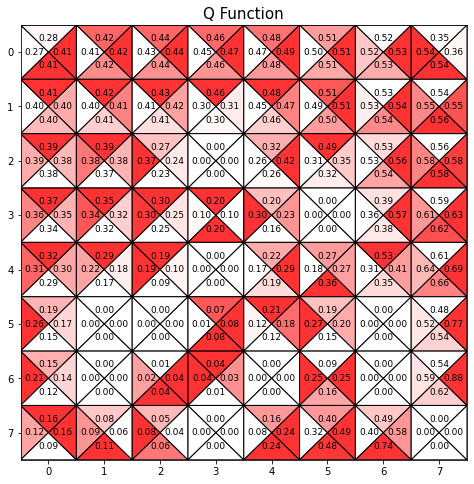

In [6]:
env = gym.make('FrozenLake8x8-v0')
obs = env.reset()
Pi,Q = q_policy_iteration(env)
display_q_value(Q, title="Q Function",fig_size=8,text_fs=9,title_fs=15)

### Now, let's move on `Monte Carlo Policy Iteration`
For model-free policy iteration,
we need to estimate the following update using samples!!

$Q_{k+1}(s,a) = \sum_{s'} \left[r(s,a,s') + \gamma \sum_{a'} Q_{k}(s',a') \pi(a'|s') \right] P(s'|s,a)$

The update rule for Q value is changed to

$Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (G_{t} - Q_{old}(S_{t}, A_{t}))$

We can update our estimator after the episode is terminated

Given $(S_{0}, A_{0}, R_{1}, S_{1}, A_{1}, R_{2}, \dots, S_{T}, A_{T}, R_{T+1}, S_{T+1})$,

$G_{t}$ can be computed using

$G_t = R_{t+1} + \gamma G_{t+1}$

Algorithm
--
---
For every episodes

Policy Evaluation

- Initialize $Q$

- $g = 0$

- $G = Q$

- For $t = T$ to $t = 0$ (backward)

> - $g = R_{t+1} + \gamma g$
> - $G[S_{t}, A_{t}] = g$

- $Q = Q + \alpha ( G - Q )$

Policy Improvement

- $\pi(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [7]:
class MCAgent():
    def __init__(self,n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.995):
        """
        Initialize Monte Carlo Learning Agent 
        """
        self.n_state = n_state
        self.n_action = n_action
        self.epsilon = epsilon # epsilon greediness
        self.alpha = alpha # Q mixing rate
        self.gamma = gamma # discount factor
        
        # Initialize Q value
        self.Q = np.zeros([n_state,n_action])
        # Memory 
        self.samples = []
        
    def save_sample(self, state, action, reward, done): 
        """
        Save experience (s, a, r, done)
        """
        self.samples.append([state, action, reward, done])
        
    def update_Q(self):
        """
        Update Q
        """
        Q_old = self.Q # [S x A]
        g = 0
        G = Q_old
        for t in reversed(range(len(self.samples))): # for all samples in a reversed way
            state,action,reward,_ = self.samples[t]
            g = reward + self.gamma*g # g = r + gamma * g
            G[state][action] = g # update G
            
        # Update Q
        self.Q = Q_old + self.alpha*(G - Q_old)
        # Empty memory
        self.samples = []
        
    def update_epsilon(self,epsilon):
        self.epsilon = np.min([epsilon,1.0]) # decay
        
    def get_action(self,state):
        """
        Get action
        """
        if np.random.uniform() < self.epsilon: # random with epsilon probability 
            action = np.random.randint(0, high=self.n_action)
        else: # greedy action
            action = np.argmax(self.Q[state])
        return action
print ("Done.")

Done.


### Run Monte Carlo Learning

In [8]:
env = gym.make('FrozenLake8x8-v0')
n_state = env.observation_space.n
n_action = env.action_space.n
M = MCAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999)

# Loop
n_episode = 10000
for e_idx in range(n_episode):
    state = env.reset() # reset environment, select initial 
    action = M.get_action(state)
    done = False
    while not done:
        next_state, reward, done, info = env.step(action) # step 
        if done:
            # Reward modification to handle sparse reward
            if reward == 0:  reward = -5 # let hole to have -1 reward
            else: reward = +10 # let goal to have +10 reward
        else:
            reward = -0.01
        next_action = M.get_action(next_state) # Get next action
        M.save_sample(state,action,reward,done) # Store samples
        state = next_state
        action = next_action
    M.update_Q() # Update Q value using sampled epsiode
    M.update_epsilon(100/(e_idx+1)) # Decaying epsilon
print ("MC learning done.")

MC learning done.


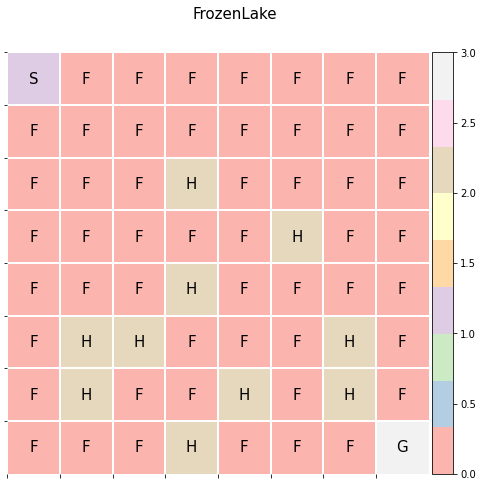

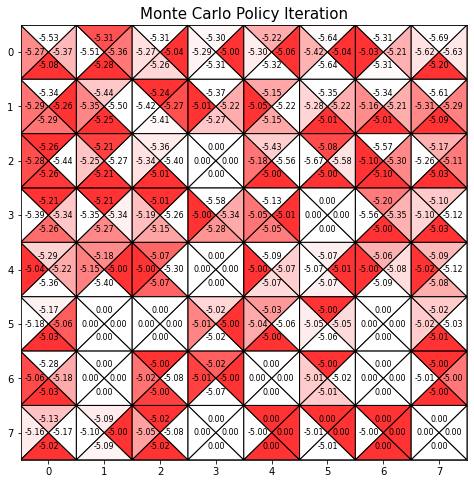

In [9]:
# Plot env
visualize_matrix(E,strs=strs,cmap='Pastel1',title='FrozenLake',fig_size=7)
# Plot Q
display_q_value(M.Q,title="Monte Carlo Policy Iteration",
                fig_size=8,text_fs=8,title_fs=15)